In [ ]:
!pip install roboflow
!pip install ultralytics
from roboflow import Roboflow
rf = Roboflow(api_key="EvFi5wlEWU3y87rr008s")
project = rf.workspace("badminton-project").project("shot-type-detection")
version = project.version(1)
dataset = version.download("yolov8")

!mv 'Shot-Type-Detection-1' 'dataset'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 22.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Shot-Type-Detection-1 in yolov8:: 100%|██████████| 1214/1214 [00:00<00:00, 7745.51it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.



image 1/1 /content/dataset/test/images/SAIT_D2_0_187_jpg.rf.df6a5d9d3e3d4214f48f8994205dadac.jpg: 640x640 3 persons, 67.5ms
Speed: 5.5ms preprocess, 67.5ms inference, 338.9ms postprocess per image at shape (1, 3, 640, 640)


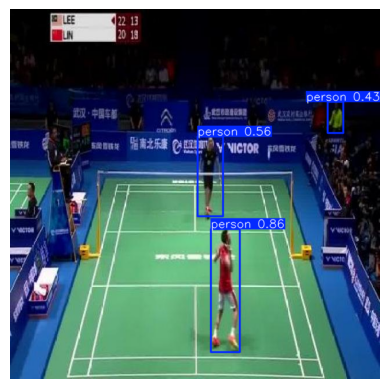

In [ ]:
!pip install ultralytics
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

model = YOLO('yolov8l.pt')

results = model('/content/dataset/test/images/SAIT_D2_0_187_jpg.rf.df6a5d9d3e3d4214f48f8994205dadac.jpg')
img = results[0].plot()

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

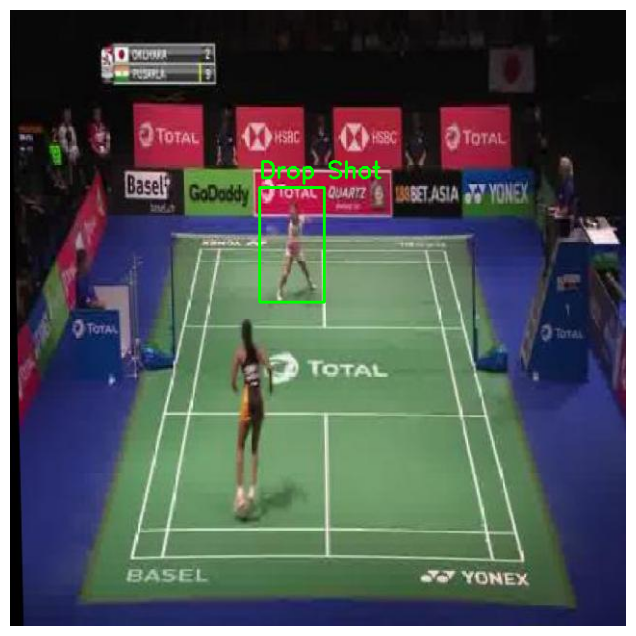

In [ ]:
import cv2
import matplotlib.pyplot as plt

class_names = [
    "Drop Shot",
    "Net Shot",
    "Over Defensive Clear",
    "Serve",
    "Smash Shot"
]

image_path = "/content/dataset/train/images/SAIT_D2_0_145_jpg.rf.8e5f5e2543a6cd6ed31d38fc676783e9.jpg"
label_path = "/content/dataset/train/labels/SAIT_D2_0_145_jpg.rf.8e5f5e2543a6cd6ed31d38fc676783e9.txt"

img = cv2.imread(image_path)
h, w = img.shape[:2]

with open(label_path, "r") as f:
    lines = f.readlines()

for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())

    # Convert YOLO format to pixel coordinates
    x_center *= w
    y_center *= h
    width *= w
    height *= h
    x1 = int(x_center - width/2)
    y1 = int(y_center - height/2)
    x2 = int(x_center + width/2)
    y2 = int(y_center + height/2)

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, class_names[int(class_id)], (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


In [ ]:
import os
import random
import shutil
from collections import defaultdict
import cv2
import numpy as np

train_dir = 'dataset/train/images'
label_dir = 'dataset/train/labels'
oversample_dir = 'dataset/train_oversampled/images'
oversample_label_dir = 'dataset/train_oversampled/labels'

os.makedirs(oversample_dir, exist_ok=True)
os.makedirs(oversample_label_dir, exist_ok=True)

class_counts = defaultdict(int)
image_classes = defaultdict(list)

for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            lines = f.readlines()
            classes_in_image = set(int(line.split()[0]) for line in lines)
            for cls_id in classes_in_image:
                class_counts[cls_id] += 1
                image_classes[cls_id].append(label_file.replace('.txt', '.jpg'))

print("Original class counts:", dict(class_counts))

max_count = max(class_counts.values())
print("Max class count:", max_count)

def augment_image(img):
    # Horizontal flip
    if random.random() < 0.5:
        img = cv2.flip(img, 1)
    # Rotation
    if random.random() < 0.5:
        angle = random.choice([90, 180, 270])
        (h, w) = img.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
        img = cv2.warpAffine(img, M, (w, h))
    # Brightness change
    if random.random() < 0.5:
        factor = 1 + (random.random() - 0.5) * 0.4  # +/-20%
        img = np.clip(img * factor, 0, 255).astype(np.uint8)
    return img

# Reset oversampled counts
oversampled_counts = defaultdict(int)

for cls_id, images in image_classes.items():
    current_count = len(images)
    extra_needed = max_count - current_count

    for img_name in images:
        shutil.copy(os.path.join(train_dir, img_name), os.path.join(oversample_dir, img_name))
        shutil.copy(os.path.join(label_dir, img_name.replace('.jpg', '.txt')),
                    os.path.join(oversample_label_dir, img_name.replace('.jpg', '.txt')))
        oversampled_counts[cls_id] += 1

    # Oversample with augmentation
    if extra_needed > 0:
        duplicates = random.choices(images, k=extra_needed)
        for i, img_name in enumerate(duplicates):
            new_img_name = img_name.replace('.jpg', f'_aug{i}.jpg')
            new_txt_name = img_name.replace('.jpg', f'_aug{i}.txt')

            # Read image and apply augmentation
            img = cv2.imread(os.path.join(train_dir, img_name))
            img_aug = augment_image(img)
            cv2.imwrite(os.path.join(oversample_dir, new_img_name), img_aug)

            # Copy label file
            shutil.copy(os.path.join(label_dir, img_name.replace('.jpg', '.txt')),
                        os.path.join(oversample_label_dir, new_txt_name))
            oversampled_counts[cls_id] += 1

print("\nOversampling completed. Balanced dataset ready at 'dataset/train_oversampled/'\n")
print("Class-wise image counts after oversampling:")
for cls_id in sorted(oversampled_counts.keys()):
    print(f"Class {cls_id}: {oversampled_counts[cls_id]} images")


Original class counts: {4: 148, 2: 67, 1: 149, 0: 171, 3: 18}
Max class count: 171

Oversampling completed. Balanced dataset ready at 'dataset/train_oversampled/'

Class-wise image counts after oversampling:
Class 0: 171 images
Class 1: 171 images
Class 2: 171 images
Class 3: 171 images
Class 4: 171 images


In [ ]:
model.train(data='dataset/data.yaml', batch = 3,augment=True,epochs=25, imgsz=416, patience = 7)

Ultralytics 8.3.192 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=3, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=7, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d09cc189520>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        


image 1/1 /content/dataset/test/images/SAIT_D2_0_234_jpg.rf.a58306f16cf9a9ba61c54aba68c176bf.jpg: 416x416 1 Drop Shot, 37.5ms
Speed: 1.9ms preprocess, 37.5ms inference, 14.0ms postprocess per image at shape (1, 3, 416, 416)


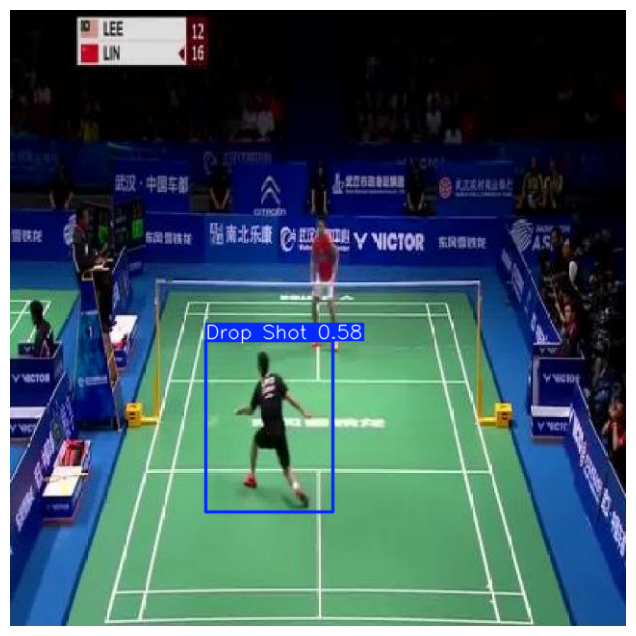

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

model = YOLO('/content/runs/detect/train/weights/best.pt')  # replace with your path
image_path = '/content/dataset/test/images/SAIT_D2_0_234_jpg.rf.a58306f16cf9a9ba61c54aba68c176bf.jpg'
results = model(image_path)
img_with_boxes = results[0].plot()
img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


In [ ]:
from ultralytics import YOLO
import cv2

model = YOLO('/content/runs/detect/train/weights/best.pt')  # path to your trained weights

input_video = '/content/badminton_match.mp4'
output_video = 'badminton_output.mp4'  # where results will be saved

results = model(input_video,show=False, save=True)



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/3198) /content/badminton_match.mp4: 256x416 (no detections), 26.4ms
video 1/1 (frame 2/3198) /content/badminton_match.mp4: 256x416 (no detections), 24.7ms
video 1/1 (frame 3/3198) /content/badminton_match.mp4: 256x416 (no detections), 21.8ms
video 1/1 (frame 4/3198) /content/badminton_match.mp4: 256x416 (no detections), 18.3ms
video 1/1 (frame 5/3198) /content/badminton_match.mp4: 256x416 (no detections), 18.3ms
video 1/1 (frame 6/31